In [2]:
import networkx as nx 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import torch_geometric 

from scipy.optimize import minimize

# Tutorial 

In this tutorial we will go over the steps to implement a GNN. For this example we will use the `karate club` dataset. 


> "A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split." 

[wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)

The specific version we will use: 

> "Zachary's karate club network from the `"An Information Flow Model for Conflict and Fission in Small Groups" <http://www1.ind.ku.dk/complexLearning/zachary1977.pdf>`_ paper, containing 34 nodes, connected by 156 (undirected and unweighted) edges.Every node is labeled by one of four classes obtained via modularity-based clustering, following the `"Semi-supervised Classification with Graph Convolutional Networks" <https://arxiv.org/abs/1609.02907>`_ paper. Training is based on a single labeled example per class, *i.e.* a total number of 4 labeled nodes." 

[pytorch](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/karate.html)


[Graph learning review paper](https://arxiv.org/abs/2105.00696)

In [3]:
# most graph learning methods operate on sparse tensors rather than the full adjacency matrix as this is more memory efficient. 
# adjacency matrices can be represented by tensors of shape (2, E) where E is the number of edges. 
# in essence, this can be thought of as edge tuple pairs that specify non-zero adjacency values, e.g., edge presence 
# for simplicity in this tutorial, we will use a small graph (34 nodes, 156 edges) and therefore memory is not an issue 
# the mathematics are simplified when using adjacency matrices. 
data = torch_geometric.datasets.KarateClub().get(0)
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [4]:
print('directed graph?', data.is_directed()) 

directed graph? False


In [5]:
G = nx.Graph([(x,y) for x,y, in zip(*data.edge_index.numpy())]) 
print('number of nodes:', len(G))
print('number of edges:', len(G.edges())) 

# note that in the edge index we had 156 "undirected" edges, but in the networkx graph of identical structure we have 78. 
# this is because networkx counts undirected edges as one edge, wheras sparse format specifies undirected edges as two edges:
# e.g., A->B   and    B->A

number of nodes: 34
number of edges: 78


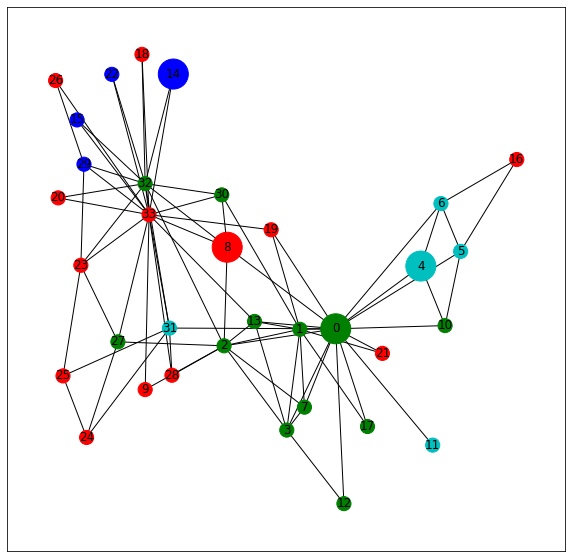

In [6]:
_c = [['r', 'g', 'b', 'c'][x] for x in data.y]

plt.figure(figsize=(10,10))
nx.draw_networkx(G, node_color=_c, node_size=data.train_mask*700 + 200)
plt.show()

# Problem goal

In this tutorial, we will implement an algorithm that learns to predict the class labels (colors in the plot above) using a subset of the nodes as training data. 

## Linear regression on graphs 

To start, let's imagine we're working with a very simple graph, visualized in the cell below.  

Now let's say that we want to predict the `node color` by using the `node size` of the graph neighbors as input, e.g., let's fit a regression of the form: 

`node color ~ node size` 

(1, 6)


array([[3.01265507, 1.02825307, 1.05028157, 1.15518211, 3.07862199,
        3.06597447],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]])

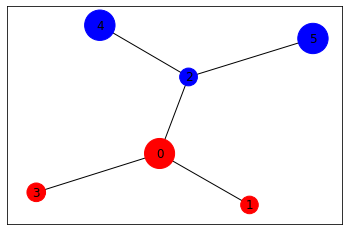

In [84]:
Gs = nx.Graph()
Gs.add_edge(0,1)
Gs.add_edge(0,2)
Gs.add_edge(0,3)
Gs.add_edge(2,4)
Gs.add_edge(2,5)

node_y = np.array([0, 0, 1, 0, 1, 1])
node_x = np.array([[3, 1, 1, 1, 3, 3]]) + np.abs(np.random.randn(6)) * 0.1 

print(node_x.shape)
# add bias term to X 
node_x = np.concatenate((node_x, np.ones((1,6))), axis=0) 

node_color = ['r','r','b', 'r', 'b', 'b']

nx.draw_networkx(Gs, node_color=node_color, node_size=node_x[0,:]*300.)

# Why do we need graph information, we can just train a regression using x and y! 

Okay, let's plot our endogenous and exogenous features...

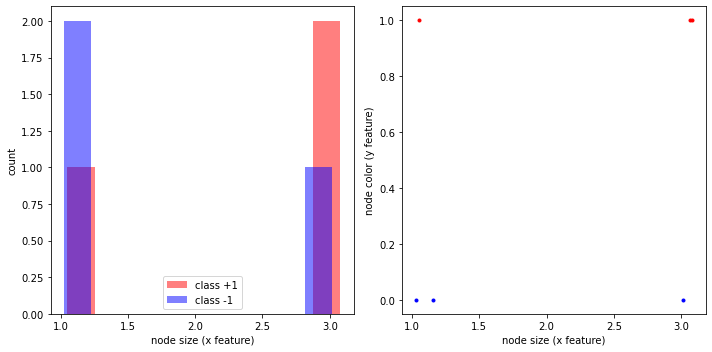

In [85]:
sel = node_y == 1

f,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(node_x[0,:][sel], color='r', alpha=0.5, label='class +1')
ax[0].hist(node_x[0,:][~sel], color='b', alpha=0.5, label='class -1')
ax[0].set_xlabel('node size (x feature)')
ax[0].set_ylabel('count')
ax[0].legend()

ax[1].plot(node_x[0,:][sel], node_y[sel], 'r.', label='class +1')
ax[1].plot(node_x[0,:][~sel], node_y[~sel], 'b.', label='class -1')
ax[1].set_xlabel('node size (x feature)')
ax[1].set_ylabel('node color (y feature)')

plt.tight_layout()
plt.show()

After inspecting our graphs above, do you think we can train a linear regression to accurately predict `node color` using `node size`? 

Why or why not? 



## Node regression using graph constraints 

So how can we use the graph information to help improve our regression? 

What if we predict each node's color by using the graph neighbors as input? So now we have more than one linear regressions to define the problem: 

$$ y_0 \sim w_{0,0} * x_0 + w_{0,1} * x_1 + w_{0,2} * x_2 + w_{0,3} * x_3 $$ 
$$ y_1 \sim w_{1,1} * x_1 + w_{1,0} * x_0 $$
$$ y_2 \sim w_{2,2} * x_2 + w_{2,0} * x_0 + w_{2,4} * x_4 + w_{2,5} * x_5 $$ 
$$ y_3 \sim w_{3,3} * x_3 + w_{3,0} * x_0 $$ 
$$ y_4 \sim w_{4,4} * x_4 + w_{4,2} * x_2 $$ 
$$ y_5 \sim w_{5,5} * x_5 + w_{5,2} * x_2 $$ 

Notice that the linear regressions above are defined by the graph structure. Compare to the graph below (re-plotted) to convince yourself of this. 


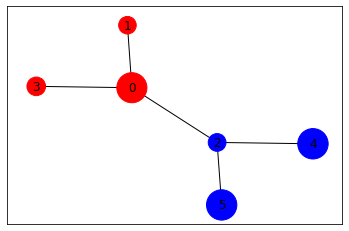

In [87]:
nx.draw_networkx(Gs, node_color=node_color, node_size=node_x[0,:]*300.)

## Boom, we're done. Plug it into an optimization algorithm, solve for $w_{i,j}$ and we're golden! 

Why does this solution not work well? 

How many training parameters do we have? 

How many training observations do we have? 

What if we don't want to include one of the nodes in the training set? Can we still apply our method to predict? e.g., will this model generalize to new graphs or data? When will it generalize and when will it not? 



## Introducing message passing 

Message passing is the concept that for some given node, we aggregate the information from it's neighboring nodes and update the node state. 

Before explaining `message passing`, let's start with the concept of a `convolution`; Often used in image processing. These are small square numerical matrices that are applied over an image like a sliding window to produce a new matrix. 

In image convolutions, this is done by aggregating nearby pixels and specific convolution weights can extract informational features from the surrounding pixels. 

<img src="https://miro.medium.com/max/1400/1*Fw-ehcNBR9byHtho-Rxbtw.gif" alt="drawing" width="500"/>

Here is an example of an image kernel (the matrix of weights) that, when applied to an image, extracts useful features (like outlines)

<img src="https://developer.nvidia.com/sites/default/files/pictures/2018/convolution-1.png" alt="drawing" width="500"/>

## So what's a graph convolution? 

In image convolutions, we take advantage of the spatial similarity of nearby pixels - with graphs we want to take advantage of nearby or connected nodes! How can we do this? 

We use a graph convolution, also sometimes refered to as message passing. Let's go back to our example from above, but instead of using individual weights for each node we're going to use a single weight with an `aggregation`; In this case, we'll use the mean.


$$ y_0 \sim \frac{1}{4} ( w * x_0 + w * x_1 + w * x_2 + w * x_3 ) $$  
$$ y_1 \sim \frac{1}{2} ( w * x_1 + w * x_0 ) $$ 
$$ y_2 \sim \frac{1}{4} ( w * x_2 + w * x_0 + w * x_4 + w * x_5 ) $$  
$$ y_3 \sim \frac{1}{2} ( w * x_3 + w * x_0 ) $$  
$$ y_4 \sim \frac{1}{2} ( w * x_4 + w * x_2 ) $$  
$$ y_5 \sim \frac{1}{2} ( w * x_5 + w * x_2 ) $$  


Now how many training parameters do we have to fit? 

Can we apply this function to new graphs or new nodes? 

Will this be capable of accurately predicting node class? 


## But this is pretty ugly... is there a prettier way to write this? 

Sure is! Let's look at how we can use the adjaceny matrix for this... 

In [89]:
# add self edges
[Gs.add_edge(i,i) for i in range(6)]

A = np.asarray( nx.adjacency_matrix(Gs).todense() )
X = node_x
y = node_y 

W = np.ones((1,2))
# set W bias term to zero for now
W[:, 1] *= 0

A

array([[1, 1, 1, 1, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 1]], dtype=int32)

In [90]:
X

array([[3.01265507, 1.02825307, 1.05028157, 1.15518211, 3.07862199,
        3.06597447],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]])

In [91]:
y

array([0, 0, 1, 0, 1, 1])

In [92]:
# This is our matrix of trainable parameters! 
W

array([[1., 0.]])

## matrix multiplication of adjacency matrix with the exogenous features 

I propose that we can write our system of equations in a matrix algebra form as: 

$ yhat = D^{-1}A*WX $ 

Where `D` is a normalization array to account for the number of incoming edges. 

```python
  # i: 0  1  2  3  4  5
D = [1/4, 1/2, 1/4, 1/2, 1/2, 1/2]
```

To convince you, let's break it down into pieces... 

1. `WX`         : This is just a simple linear feature transfomation; in our case `W` is just a single parameter but `X` is a matrix. For now, we'll use a W value of 1, which simplifes to `WX` to `X`. 

2. `DA`         : This normalizes our adjacency matrix by row. 

3. `(DA) (WX)`  : This is the step that sums all features of neighboring nodes. Since we've normalize by row this computes the mean X value of all neighbors. 

To visualize how this works, here is the first row of our adjacency matrix again: 

$$ [1, 1, 1, 1, 0, 0] $$

Note that this row specifies the neighbors of `node 0`, and the second row of the adjacency matrix specifies the neighbors of `node 1` ... etc etc 

So we can get the sum of `node 0` neighbors `X` features by element wise multiplication with X; Only non-zero values are selected! 

Note that this is exactly what matrix multiplication does! 

 ## Let's see it in action...


In [93]:
Dinv = 1 / np.sum(A, axis=0)
Dinv = Dinv
Dinv

array([0.25, 0.5 , 0.25, 0.5 , 0.5 , 0.5 ])

In [94]:
A2 = (Dinv * A).T
A2

array([[0.25, 0.25, 0.25, 0.25, 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.25, 0.  , 0.25, 0.25],
       [0.5 , 0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.5 ]])

In [100]:
X2 = W @ X
X2

array([[3.01265507, 1.02825307, 1.05028157, 1.15518211, 3.07862199,
        3.06597447]])

In [101]:
# node 0 sum 
A2[0, :] @ X2.T

array([1.56159295])

In [102]:
# node 1 sum 
A2[1, :] @ X2.T

array([2.02045407])

In [103]:
# now linear matrix form: 
# (compare the first two elements)
yhat = A2 @ X2.T

yhat = yhat.ravel()
yhat

array([1.56159295, 2.02045407, 2.55188327, 2.08391859, 2.06445178,
       2.05812802])

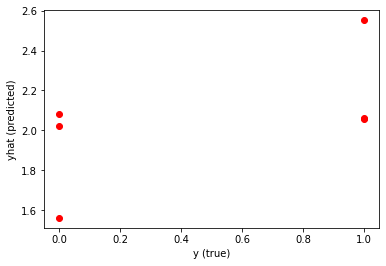

In [104]:
# Now let's plot the results of our graph transformed features 
plt.figure()
plt.plot(y, yhat, 'ro')
plt.xlabel('y (true)')
plt.ylabel('yhat (predicted)')
plt.show()

## Improved but still not perfect, we still don't have great separation between classes. 

Let's try running multiple convolutions. Here's the idea... 

$$ first \ layer: \ \ \ h_1 = DAWX   $$ 
$$ second \ layer: \ \ \ h_2 = DAWh_1 $$ 
$$ third \ layer: \ \ \ h_3 = DAWh_2 $$

Here is a nice visualization of how message passing can operate over multiple layers. 


<img src="https://www.outsystems.com/blog/-/media/images/blog/posts/graph-neural-networks/nn-gif-5.gif?h=393&w=750&updated=20190809155049" alt="drawing" width="500"/>


In [105]:
X

array([[3.01265507, 1.02825307, 1.05028157, 1.15518211, 3.07862199,
        3.06597447],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]])

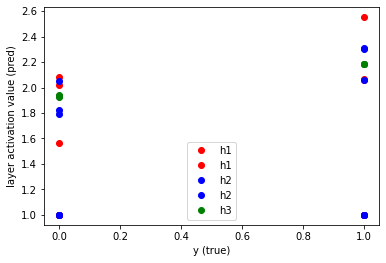

In [110]:
bias = np.ones((6,1))

h1 = (Dinv * A).T @ (W @ X).T
h1 = np.concatenate((h1, bias), axis=1)

h2 = (Dinv * A).T @ (W @ h1.T).T
h2 = np.concatenate((h2, bias), axis=1)

h3 = (Dinv * A).T @ (W @ h2.T).T

plt.figure()
plt.plot(y, h1, 'ro', label='h1')
plt.plot(y, h2, 'bo', label='h2')
plt.plot(y, h3, 'go', label='h3')
plt.xlabel('y (true)')
plt.ylabel('layer activation value (pred)')
plt.legend()
plt.show()

In [117]:
def f(w): 
    w = w.reshape(-1,2)

    bias = np.ones((6,1))

    h1 = (Dinv * A).T @ (w @ X).T
    h1 = np.concatenate((h1, bias), axis=1)

    h2 = (Dinv * A).T @ (w @ h1.T).T
    h2 = np.concatenate((h2, bias), axis=1)

    h3 = (Dinv * A).T @ (w @ h2.T).T

    mse = np.mean((h3 - y)**2)

    return mse

res = minimize(f, x0=[W], method='nelder-mead')
print('optimized parameters (w):', res.x)
print('minimized mse value:', f(res.x))

optimized parameters (w): [0.00516027 0.49741966]
minimized mse value: 0.2500000000000002


In [119]:
def f2(w): 
    w = w.reshape(-1,2)
    bias = np.ones((6,1))
    h1 = (Dinv * A).T @ (w @ X).T
    h1 = np.concatenate((h1, bias), axis=1)
    h2 = (Dinv * A).T @ (w @ h1.T).T
    h2 = np.concatenate((h2, bias), axis=1)
    h3 = (Dinv * A).T @ (w @ h2.T).T
    return h3

f2(res.x)

array([[0.49999999],
       [0.49999998],
       [0.50000002],
       [0.49999999],
       [0.50000002],
       [0.50000002]])

No handles with labels found to put in legend.


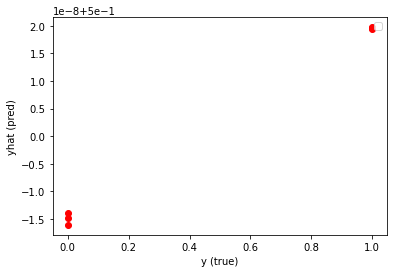

In [120]:
plt.figure()
plt.plot(y, f2(res.x).ravel(), 'ro')
plt.xlabel('y (true)')
plt.ylabel('yhat (pred)')
plt.legend()
plt.show()

In [ ]:
# TODOs 

# 1. Change to classfication problem 

# 2. Use a "biological example" instead of node size and color 

# 3. add larger true biological example as the HW assignment. 

# 4. 